In [3]:
import cv2
import numpy as np
import os
import glob
from skimage.restoration import denoise_tv_chambolle, denoise_tv_bregman
from skimage import img_as_ubyte
from skimage import io, color, exposure, img_as_float, img_as_ubyte
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set
from scipy import ndimage
from tqdm import tqdm 

# 0. 이미지 뭉개기

In [2]:

# =================================================
#             1. Image Denoising
# =================================================
        # Total Variation (TV) Denoising을 사용해 데이터 스머징
        # 목적 : 이미지를 뭉개서 최대한 뭉뚝한 마스크를 생성하기 위함.
def apply_tv_denoising(input_folder, output_folder, weight=0.1):
    """
    폴더 내 모든 이미지에 Total Variation Denoising을 적용합니다.
    
    :param weight: Denoising 강도 (클수록 더 뭉개짐/부드러워짐).
                   X-ray의 경우 보통 0.05 ~ 0.2 사이가 적당합니다.
    """
    # 1. 출력 폴더 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # 2. 이미지 파일 리스트 가져오기
    image_files = glob.glob(os.path.join(input_folder, '*.png'))
    # jpg도 있다면 아래 주석 해제
    # image_files.extend(glob.glob(os.path.join(input_folder, '*.jpg')))
    
    print(f"🚀 총 {len(image_files)}장 TV Denoising 시작 (Weight={weight})...")
    
    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 3. 이미지 로드 (GrayScale)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
            
        # 4. TV Denoising 적용 (Chambolle 알고리즘)
        # weight: 노이즈 제거 강도. 값이 클수록 이미지가 더 매끄러워(cartoon-like)집니다.
        # 보여주신 예시는 꽤 강하게 들어간 편이라 0.1~0.2 정도가 적당해 보입니다.
        denoised_float = denoise_tv_chambolle(img, weight=weight, channel_axis=None)
        
        # 5. 결과 변환 (Float 0~1 -> Uint8 0~255)
        # skimage 결과는 float 형태이므로 다시 이미지 포맷으로 변환해야 합니다.
        denoised_img = img_as_ubyte(denoised_float)
        
        # 6. 저장
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, denoised_img)
        
    print("-" * 50)
    print("✅ 모든 이미지 변환 완료!")
    print(f"📂 저장 경로: {output_folder}")
    print("-" * 50)



In [ ]:

# =================================================
#             실행
# =================================================
input_dir = "D:/lung_xray/final_imgsets" # 원본 이미지 폴더
output_dir = "D:/lung_xray/final_denoised"    # 결과 저장될 폴더

# weight 값을 조절하여 원하는 뭉개짐 정도를 찾으세요.
# 0.05 (약함) -> 0.1 (보통/추천) -> 0.2 (강함/예시 사진과 비슷)
apply_tv_denoising(input_dir, output_dir, weight=0.15)

In [ ]:
# 성능평가용 JSRT 데이터셋
# =================================================
#             실행
# =================================================
input_dir = "D:/nodules-in-chest-xrays-jsrt/images_clean" # 원본 이미지 폴더
output_dir = "D:/nodules-in-chest-xrays-jsrt/images_denoised"    # 결과 저장될 폴더

# weight 값을 조절하여 원하는 뭉개짐 정도를 찾으세요.
# 0.05 (약함) -> 0.1 (보통/추천) -> 0.2 (강함/예시 사진과 비슷)
apply_tv_denoising(input_dir, output_dir, weight=0.15)

🚀 총 247장 TV Denoising 시작 (Weight=0.15)...


 29%|██▊       | 71/247 [08:34<20:14,  6.90s/it]

폐 영역을 인식하고 마스킹하여 전용 마스크 생성

 ### 1. 흉부 마스크 생성

마스크 폴더 위치 :  "D:/lung_xray/final_denoised/lung_mask"

In [4]:
# =========================================================
# [1] 핵심 알고리즘 함수 정의
# =========================================================

def calculate_isodata_threshold(img):
    """ISODATA 알고리즘으로 최적 임계값 계산"""
    T = np.mean(img)
    prev_T = -1
    while abs(T - prev_T) > 0.5:
        prev_T = T
        background = img[img >= T]
        foreground = img[img < T]
        m_bg = np.mean(background) if len(background) > 0 else 255
        m_fg = np.mean(foreground) if len(foreground) > 0 else 0
        T = (m_bg + m_fg) / 2
    return int(T)

def evaluate_segmentation_quality(mask, img_shape):
    """폐 영역 품질 검사 (면적 비율 및 덩어리 개수)"""
    H, W = img_shape
    total_area = H * W
    mask_area = np.count_nonzero(mask)
    ratio = mask_area / total_area

    # 조건: 폐는 전체의 10% ~ 60% 사이여야 함
    if ratio < 0.10: return False, "Area too small (Low Contrast suspected)"
    if ratio > 0.60: return False, "Area too large"
    
    # 조건: 큰 덩어리가 최소 1개 이상 잡혀야 함
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_blobs = [cnt for cnt in contours if cv2.contourArea(cnt) > (total_area * 0.01)]
    if len(large_blobs) < 1: return False, "No significant blobs"
    
    return True, "Satisfactory"

def enhance_black_contrast(img, depth):
    """
    [요구사항 3] 대비가 약해 인식이 안될 경우, 검은 비율을 높이는 효과 적용.
    Gamma Correction을 사용하여 depth가 깊어질수록 중간톤(회색)을 검은색으로 강하게 보냄.
    Depth 0: 원본
    Depth 1: Gamma 1.5 (진하게)
    Depth 2: Gamma 2.0 (더 진하게) ...
    """
    # 210 이상은 무조건 흰색(뼈)으로 날림 (Hard Constraint)
    img_clipped = img.copy()
    img_clipped[img_clipped >= 210] = 255
    
    # 감마 값 계산 (깊을수록 1.0 -> 1.5 -> 2.0 ... 증가)
    gamma = 1.0 + (depth * 0.5) 
    
    # 감마 보정 적용 (값이 클수록 이미지가 어두워지고 대비가 강해짐)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    enhanced = cv2.LUT(img_clipped, table)
    
    # CLAHE로 국소 대비 추가 확보
    clahe = cv2.createCLAHE(clipLimit=(2.0 + depth), tileGridSize=(8, 8))
    final = clahe.apply(enhanced)
    
    return final

def recursive_isodata_segmentation(img, depth=0, max_depth=3):
    """재귀적 분할 로직"""
    H, W = img.shape
    
    # 1. 대비 강화 전처리 (검은 비율 높이기)
    processed_img = enhance_black_contrast(img, depth)
    
    # 2. ISODATA 임계값 찾기
    threshold = calculate_isodata_threshold(processed_img)
    
    # 3. 마스크 생성
    _, binary_mask = cv2.threshold(processed_img, threshold, 255, cv2.THRESH_BINARY_INV)
    
    # 4. 품질 검사
    is_good, reason = evaluate_segmentation_quality(binary_mask, (H, W))
    
    if is_good:
        return binary_mask
    else:
        # 실패 시 재귀 호출 (Depth 증가 -> 대비 더 강하게)
        if depth < max_depth:
            # tqdm.write를 사용하여 진행바 깨짐 방지
            # tqdm.write(f"   ㄴ[Retry] Depth {depth} failed ({reason}). Increasing contrast (Gamma Lv.{depth+1})...")
            return recursive_isodata_segmentation(img, depth=depth+1, max_depth=max_depth)
        else:
            return binary_mask # 최선책 반환

# =========================================================
# [2] 메인 실행 루프
# =========================================================

def process_all_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 이미지 파일 리스트 확보
    extensions = ['*.png', '*.jpg', '*.jpeg']
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(input_folder, ext)))
    
    total_files = len(image_files)
    print(f"🚀 총 {total_files}장의 이미지 처리를 시작합니다.")

    # tqdm으로 진행바 생성
    for i, file_path in enumerate(tqdm(image_files)):
        filename = os.path.basename(file_path)
        save_path = os.path.join(output_folder, filename)
        
        try:
            # 이미지 로드
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            
            # 리사이즈 (속도 최적화)
            img_resized = cv2.resize(img, (512, 512))

            # --- [핵심] 재귀적 분할 실행 ---
            final_mask = recursive_isodata_segmentation(img_resized)
            
            # 원본 크기로 마스크 복원 (선택 사항)
            final_mask_full = cv2.resize(final_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            
            # 저장
            cv2.imwrite(save_path, final_mask_full)

            # --- [요구사항 2] 1000번째 이미지마다 로그 출력 ---
            # (i + 1)을 하는 이유는 i가 0부터 시작하기 때문
            if (i + 1) % 1000 == 0:
                tqdm.write(f"[System Log] 현재 {i + 1} / {total_files} 장 처리 완료...")

        except Exception as e:
            # 에러 메시지도 tqdm.write로 출력해야 진행바가 안 깨짐
            tqdm.write(f"[Error] {filename}: {e}")

    print("\n🎉 모든 처리가 완료되었습니다.")



In [5]:
# =========================================================
# [3] 실행 경로 설정 - 샘플버전
# =========================================================
input_dir = "D:/nodules-in-chest-xrays-jsrt/images_clean"   # 원본 이미지가 있는 폴더
output_dir = "D:/nodules-in-chest-xrays-jsrt/lung_mask" # 결과를 저장할 폴더

# =========================================================
# [3] 실행 경로 설정
# =========================================================
# input_dir = "D:/lung_xray/final_denoised"   # 원본 이미지가 있는 폴더
# output_dir = "D:/lung_xray/final_denoised/lung_mask" # 결과를 저장할 폴더

process_all_images(input_dir, output_dir)

🚀 총 247장의 이미지 처리를 시작합니다.


  0%|          | 0/247 [00:00<?, ?it/s]

100%|██████████| 247/247 [00:12<00:00, 19.24it/s]


🎉 모든 처리가 완료되었습니다.


## 폐 영역 인식(바운딩 박스)

### 단일 코드

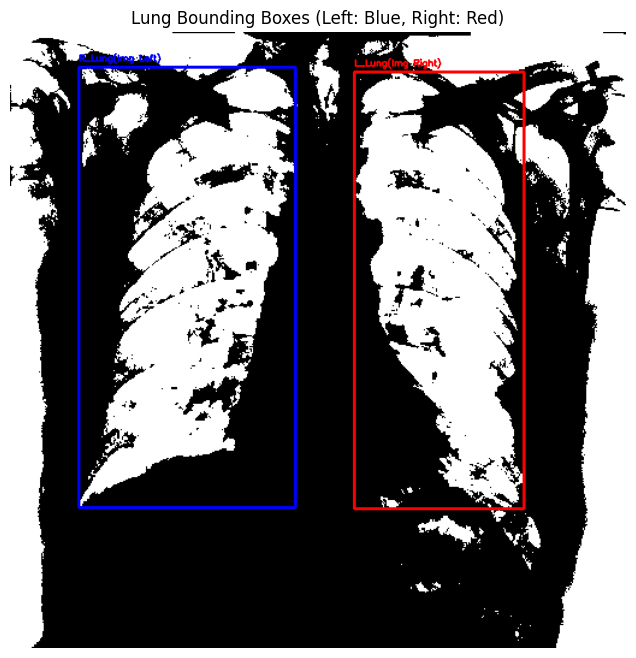

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_lung_boxes(mask_path):
    # 1. 마스크 이미지 로드 (GrayScale)
    # 배경은 검은색(0), 폐는 흰색(255)이어야 합니다.
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("이미지를 찾을 수 없습니다.")
        return

    # 컬러로 변환 (박스를 색깔별로 그리기 위해)
    output_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # 2. 윤곽선(Contours) 검출
    # 흰색 덩어리의 외곽선을 찾습니다.
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. 덩어리 필터링: 면적 기준 정렬 (가장 큰 2개만 선택)
    # 폐가 쪼개져서 잡히는 경우를 대비해, 가장 큰 2개만 '폐'라고 가정합니다.
    sorted_cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # 덩어리가 2개 미만일 경우 예외 처리
    if len(sorted_cnts) == 0:
        print("폐 영역(흰색 덩어리)이 검출되지 않았습니다.")
        return output_img

    # 4. 좌/우 구분: X 좌표 기준 정렬
    # x좌표가 작으면 왼쪽 덩어리, 크면 오른쪽 덩어리
    # key=lambda c: cv2.boundingRect(c)[0] -> x좌표만 뽑아서 비교
    sorted_by_x = sorted(sorted_cnts, key=lambda c: cv2.boundingRect(c)[0])

    # 5. 박스 그리기 (사용자 아이디어 적용)
    # OpenCV 색상 순서: BGR (Blue, Green, Red)
    
    # --- [왼쪽 덩어리] -> 파란색 (Blue) ---
    if len(sorted_by_x) > 0:
        left_blob = sorted_by_x[0]
        x, y, w, h = cv2.boundingRect(left_blob)
        # (x, y)는 좌상단, (x+w, y+h)는 우하단 좌표입니다.
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 3) # Blue
        
        # (옵션) 텍스트 표시
        cv2.putText(output_img, "R_Lung(Img Left)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    # --- [오른쪽 덩어리] -> 빨간색 (Red) ---
    if len(sorted_by_x) > 1:
        right_blob = sorted_by_x[1]
        x, y, w, h = cv2.boundingRect(right_blob)
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 3) # Red
        
        # (옵션) 텍스트 표시
        cv2.putText(output_img, "L_Lung(Img Right)", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

    return output_img

# --- 실행 및 시각화 ---
# 앞서 생성한 마스크 파일 경로를 넣어주세요
mask_file = "C:/project/lungX/CXR8/image_set/PA/No Finding/masks/00000002_000.png"

result = draw_lung_boxes(mask_file)

if result is not None:
    # matplotlib는 RGB 순서이므로 BGR -> RGB 변환 후 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title("Lung Bounding Boxes (Left: Blue, Right: Red)")
    plt.axis('off')
    plt.show()

### 전체 실행 코드

In [ ]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set

In [73]:

# 첫번째 시안. 
# 문제점 : ㅈㄴ 많아서 버려야해
def process_lung_bboxes(input_folder, output_img_folder, output_csv_path):
    # ---------------------------------------------------------
    # [설정] 폴더 생성 및 초기화
    # ---------------------------------------------------------
    if not os.path.exists(output_img_folder):
        os.makedirs(output_img_folder)
        print(f"📂 결과 이미지 저장 폴더 생성: {output_img_folder}")

    # CSV에 저장할 데이터를 담을 리스트
    bbox_data_list = []

    # 입력 폴더 내 모든 이미지 파일 가져오기 (png, jpg 등)
    image_files = glob.glob(os.path.join(input_folder, '*.png')) 
    # 필요시 확장자 추가: image_files.extend(glob.glob(os.path.join(input_folder, '*.jpg')))

    print(f"🚀 총 {len(image_files)}장의 마스크 처리를 시작합니다...")

    # ---------------------------------------------------------
    # [Loop] 모든 이미지에 대해 반복 실행
    # ---------------------------------------------------------
    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 마스크 로드
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ 로드 실패: {filename}")
            continue

        # 컬러 변환 (시각화용)
        output_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # 2. 윤곽선 검출
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 3. 덩어리 필터링 (가장 큰 2개 선택)
        sorted_cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

        # 데이터 저장을 위한 초기값 (못 찾았을 경우 None 처리)
        # R_Lung (이미지 왼쪽, 파란박스), L_Lung (이미지 오른쪽, 빨간박스)
        r_lung_coords = [None, None, None, None] # x_min, y_min, x_max, y_max
        l_lung_coords = [None, None, None, None]

        if len(sorted_cnts) > 0:
            # 4. 좌/우 구분 (X좌표 기준 정렬)
            # x좌표가 작은 것(0번)이 이미지 왼쪽 -> 환자의 우폐(R_Lung)
            sorted_by_x = sorted(sorted_cnts, key=lambda c: cv2.boundingRect(c)[0])
            
            # --- [왼쪽 덩어리: R_Lung] ---
            # sorted_by_x[0]은 무조건 가장 왼쪽에 있는 덩어리
            blob_left = sorted_by_x[0]
            x, y, w, h = cv2.boundingRect(blob_left)
            
            # 좌표 계산
            x_min, y_min = x, y
            x_max, y_max = x + w, y + h
            
            # 그리기 (파란색)
            cv2.rectangle(output_img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
            cv2.putText(output_img, "R_Lung", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
            
            # 데이터 기록
            r_lung_coords = [x_min, y_min, x_max, y_max]

            # --- [오른쪽 덩어리: L_Lung] ---
            # 덩어리가 2개 이상일 때만 존재
            if len(sorted_by_x) > 1:
                blob_right = sorted_by_x[1]
                x, y, w, h = cv2.boundingRect(blob_right)
                
                x_min, y_min = x, y
                x_max, y_max = x + w, y + h
                
                # 그리기 (빨간색)
                cv2.rectangle(output_img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 3)
                cv2.putText(output_img, "L_Lung", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
                
                # 데이터 기록
                l_lung_coords = [x_min, y_min, x_max, y_max]

        # 5. 결과 이미지 저장
        save_path = os.path.join(output_img_folder, filename)
        cv2.imwrite(save_path, output_img)

        # 6. CSV 데이터 리스트에 추가
        # 구조: [파일명, R_xmin, R_ymin, R_xmax, R_ymax, L_xmin, L_ymin, L_xmax, L_ymax]
        row = [filename] + r_lung_coords + l_lung_coords
        bbox_data_list.append(row)

    # ---------------------------------------------------------
    # [Final] CSV 파일 생성 및 저장
    # ---------------------------------------------------------
    columns = [
        'Image Index', 
        'R_Lung_Xmin', 'R_Lung_Ymin', 'R_Lung_Xmax', 'R_Lung_Ymax',
        'L_Lung_Xmin', 'L_Lung_Ymin', 'L_Lung_Xmax', 'L_Lung_Ymax'
    ]
    
    df = pd.DataFrame(bbox_data_list, columns=columns)
    df.to_csv(output_csv_path, index=False)
    
    print("-" * 50)
    print(f"🎉 처리 완료!")
    print(f"📊 CSV 저장 위치: {output_csv_path}")
    print(f"🖼️ 이미지 저장 위치: {output_img_folder}")
    print("-" * 50)
    
    # 미리보기
    print(df.head())





좌우, 위아래를 10% 축소한 범위에서 폐 덩어리(흰 영역)가 있는 중앙 spot찾음. 가장 큰 두 개의 덩어리를 잡음. 그리고 이 두개의 spot사이에 검은색 영역(폐와 폐 사이의 빈공간)이 있는지 검증.



그 다음 좌우, 위아래를 10% 축소하지 않은 범위(원본 범위)에서 두 개의 중앙spot을 seed로 폐 영역을 인식하여 bounding box


중앙spot이 검은 영역일 경우 바운딩 박스진행되지 않음. 중앙spot주변 2%영역은 cleaning또는 bluring하여 흰색 영역으로 만들어줘야함.

In [97]:
def process_lung_smart_bboxes_fixed(input_folder, output_img_folder, output_csv_path):
    # ---------------------------------------------------------
    # [설정] 폴더 생성
    # ---------------------------------------------------------
    if not os.path.exists(output_img_folder):
        os.makedirs(output_img_folder)

    bbox_data_list = []
    
    # 이미지 파일 리스트
    image_files = glob.glob(os.path.join(input_folder, '*.png'))
    
    print(f"🚀 총 {len(image_files)}장의 이미지 처리를 시작합니다...")
    print("Logic: ROI Seed Search -> [Fix: Seed Area Filling] -> Gap Check -> Expansion")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 이미지 로드 및 이진화
        original_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if original_img is None:
            continue
            
        _, bin_img = cv2.threshold(original_img, 127, 255, cv2.THRESH_BINARY)
        
        h, w = bin_img.shape
        output_vis = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR) # 시각화용

        # ---------------------------------------------------------
        # Step 1: 좌우/위아래 10% 축소한 ROI 생성
        # ---------------------------------------------------------
        margin_h = int(h * 0.2)
        margin_w = int(w * 0.2)

        roi_img = bin_img[margin_h : h - margin_h, margin_w : w - margin_w]

        # ROI 윤곽선 및 무게중심 찾기
        contours, _ = cv2.findContours(roi_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sorted_cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

        # ---------------------------------------------------------
        # Step 2: Seed 찾기 및 [Hole Patching]
        # ---------------------------------------------------------
        seeds = [] 
        
        # 20% 영역 계산 (짧은 변 기준)
        patch_radius = int(min(h, w) * 0.2)
        if patch_radius < 1: patch_radius = 1 # 최소 1픽셀 보장

        for cnt in sorted_cnts:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                
                global_x = cX + margin_w
                global_y = cY + margin_h
                seeds.append((global_x, global_y))
                
                # 🚨 [핵심 수정] Seed 위치가 검은색(구멍)일 수 있으므로
                # 원본 마스크(bin_img)의 해당 위치에 강제로 흰색 원을 그려 채워버림
                # -1 옵션은 내부를 꽉 채움(Fill)
                cv2.circle(bin_img, (global_x, global_y), patch_radius, 255, -1)
                
                # 시각화에도 표시 (주황색 원)
                cv2.circle(output_vis, (global_x, global_y), patch_radius, (0, 165, 255), 2)

        # ---------------------------------------------------------
        # Step 3: 검증 (Gap Check)
        # ---------------------------------------------------------
        is_valid_pair = False
        
        if len(seeds) == 2:
            seeds.sort(key=lambda p: p[0]) 
            seed_l = seeds[0] 
            seed_r = seeds[1] 

            # 폐 사이 중간 지점 확인
            mid_x = (seed_l[0] + seed_r[0]) // 2
            mid_y = (seed_l[1] + seed_r[1]) // 2

            # 중간 지점이 검은색인지 확인 (여전히 폐가 분리되어 있는지)
            if bin_img[mid_y, mid_x] == 0:
                is_valid_pair = True
                cv2.circle(output_vis, (mid_x, mid_y), 3, (0, 255, 0), -1) 

        # ---------------------------------------------------------
        # Step 4: 원본 범위 확장 (채워진 bin_img 사용)
        # ---------------------------------------------------------
        r_coords = [None, None, None, None]
        l_coords = [None, None, None, None]

        if is_valid_pair:
            # 🚨 구멍이 메워진 bin_img를 사용하여 컴포넌트 분석 수행
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img)

            label_idx_l = labels[seed_l[1], seed_l[0]]
            label_idx_r = labels[seed_r[1], seed_r[0]]

            # R_Lung Processing
            if label_idx_l != 0:
                x, y, w_box, h_box, area = stats[label_idx_l]
                r_coords = [x, y, x+w_box, y+h_box]
                cv2.rectangle(output_vis, (x, y), (x+w_box, y+h_box), (255, 0, 0), 3)
                cv2.putText(output_vis, "R_Lung", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

            # L_Lung Processing
            if label_idx_r != 0:
                x, y, w_box, h_box, area = stats[label_idx_r]
                l_coords = [x, y, x+w_box, y+h_box]
                cv2.rectangle(output_vis, (x, y), (x+w_box, y+h_box), (0, 0, 255), 3)
                cv2.putText(output_vis, "L_Lung", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
        
        else:
            cv2.putText(output_vis, "Detection Failed", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        # 5. 저장
        cv2.imwrite(os.path.join(output_img_folder, filename), output_vis)
        
        # 6. 데이터 추가
        row = [filename] + r_coords + l_coords
        bbox_data_list.append(row)

    # ---------------------------------------------------------
    # [Final] CSV 저장
    # ---------------------------------------------------------
    columns = [
        'Image Index', 
        'R_Lung_Xmin', 'R_Lung_Ymin', 'R_Lung_Xmax', 'R_Lung_Ymax',
        'L_Lung_Xmin', 'L_Lung_Ymin', 'L_Lung_Xmax', 'L_Lung_Ymax'
    ]
    df = pd.DataFrame(bbox_data_list, columns=columns)
    df.to_csv(output_csv_path, index=False)
    
    print("\n✅ 처리가 완료되었습니다.")

검은 영역 안에 들어가있는 두 개의 가장 큰 흰색 영역의 중앙spot을 잡음. 사이검증(두개의 흰 영역 사이에 검은 영역이 있는지) 필수.




In [104]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm

def process_lung_bboxes_final(input_folder, output_img_folder, output_csv_path):
    # ---------------------------------------------------------
    # [설정] 폴더 생성
    # ---------------------------------------------------------
    if not os.path.exists(output_img_folder):
        os.makedirs(output_img_folder)

    bbox_data_list = []
    
    image_files = glob.glob(os.path.join(input_folder, '*.png'))
    
    print(f"🚀 총 {len(image_files)}장의 이미지 처리를 시작합니다...")
    print("Logic: Top 2 White Blobs -> Hole Patching -> Gap Verification -> BBox")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 이미지 로드 (이진화 보장)
        original_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if original_img is None:
            continue
            
        _, bin_img = cv2.threshold(original_img, 127, 255, cv2.THRESH_BINARY)
        
        h, w = bin_img.shape
        output_vis = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR) # 결과 확인용

        # ---------------------------------------------------------
        # Step 1: 20% 축소된 ROI에서 안전한 Seed 찾기
        # ---------------------------------------------------------
        margin_h = int(h * 0.2)
        margin_w = int(w * 0.2)

        # ROI 추출
        roi_img = bin_img[margin_h : h - margin_h, margin_w : w - margin_w]

        # ROI 내에서 흰색 덩어리(Contours) 찾기
        contours, _ = cv2.findContours(roi_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 면적 기준 내림차순 정렬 후 상위 2개 선택 (가장 큰 두 흰색 영역)
        sorted_cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

        seeds = [] 
        
        # ---------------------------------------------------------
        # Step 2: Seed 좌표 계산 및 [Hole Patching]
        # ---------------------------------------------------------
        # 10% 크기의 패치 반지름 계산 (구멍 메우기용)
        patch_radius = int(min(h, w) * 0.1)
        if patch_radius < 1: patch_radius = 1

        for cnt in sorted_cnts:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                
                # ROI 좌표 -> 원본 좌표 변환
                global_x = cX + margin_w
                global_y = cY + margin_h
                seeds.append((global_x, global_y))
                
                # 🛠️ [Fix] 만약 Seed 위치가 검은색(구멍/병변)이라면 흰색으로 메워버림
                # ConnectedComponents가 끊기지 않도록 다리를 놓아주는 역할
                if bin_img[global_y, global_x] == 0:
                    cv2.circle(bin_img, (global_x, global_y), patch_radius, 255, -1)
                    # 시각화: 메운 곳 표시 (주황색)
                    cv2.circle(output_vis, (global_x, global_y), patch_radius, (0, 165, 255), 2)
                else:
                    # 구멍이 아니어도 안전하게 확장성을 위해 살짝 칠해줌 (선택사항)
                    cv2.circle(bin_img, (global_x, global_y), 2, 255, -1)

        # ---------------------------------------------------------
        # Step 3: [Gap Verification] 사이 검증
        # ---------------------------------------------------------
        is_valid = False
        
        if len(seeds) == 2:
            seeds.sort(key=lambda p: p[0]) # X좌표 기준 정렬 (좌/우)
            seed_l = seeds[0] # R_Lung (이미지상 왼쪽)
            seed_r = seeds[1] # L_Lung (이미지상 오른쪽)

            # 두 Seed의 정중앙 지점 계산
            mid_x = (seed_l[0] + seed_r[0]) // 2
            mid_y = (seed_l[1] + seed_r[1]) // 2

            # 🔎 검증: 중간 지점이 '검은색(0)'인가?
            # 검은색이어야 두 폐가 분리되어 있다는 뜻
            if bin_img[mid_y, mid_x] == 0:
                is_valid = True
                cv2.circle(output_vis, (mid_x, mid_y), 5, (0, 255, 0), -1) # 초록점 (통과)
            else:
                # 중간이 흰색이면 두 폐가 붙어있거나 엉뚱한 덩어리임
                cv2.circle(output_vis, (mid_x, mid_y), 5, (0, 0, 255), -1) # 빨간점 (실패)

        # ---------------------------------------------------------
        # Step 4: 최종 Bounding Box 추출
        # ---------------------------------------------------------
        r_coords = [None, None, None, None]
        l_coords = [None, None, None, None]

        if is_valid:
            # 구멍이 메워진 bin_img를 사용하여 전체 덩어리 분석
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_img)

            # 각 Seed가 포함된 라벨 번호 찾기
            idx_l = labels[seed_l[1], seed_l[0]]
            idx_r = labels[seed_r[1], seed_r[0]]

            # --- [오른쪽 폐 (이미지 왼쪽)] ---
            if idx_l != 0: # 0은 배경
                x, y, w_box, h_box, area = stats[idx_l]
                r_coords = [x, y, x+w_box, y+h_box]
                cv2.rectangle(output_vis, (x, y), (x+w_box, y+h_box), (255, 0, 0), 3)
                cv2.putText(output_vis, "R_Lung", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

            # --- [왼쪽 폐 (이미지 오른쪽)] ---
            if idx_r != 0:
                x, y, w_box, h_box, area = stats[idx_r]
                l_coords = [x, y, x+w_box, y+h_box]
                cv2.rectangle(output_vis, (x, y), (x+w_box, y+h_box), (0, 0, 255), 3)
                cv2.putText(output_vis, "L_Lung", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
        
        else:
            cv2.putText(output_vis, "Verification Failed", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # 5. 결과 저장
        cv2.imwrite(os.path.join(output_img_folder, filename), output_vis)
        
        # 6. CSV 데이터 추가
        row = [filename] + r_coords + l_coords
        bbox_data_list.append(row)

    # ---------------------------------------------------------
    # [Final] CSV 파일 생성
    # ---------------------------------------------------------
    columns = [
        'Image Index', 
        'R_Lung_Xmin', 'R_Lung_Ymin', 'R_Lung_Xmax', 'R_Lung_Ymax',
        'L_Lung_Xmin', 'L_Lung_Ymin', 'L_Lung_Xmax', 'L_Lung_Ymax'
    ]
    df = pd.DataFrame(bbox_data_list, columns=columns)
    df.to_csv(output_csv_path, index=False)
    
    print("\n✅ 처리가 완료되었습니다.")

(Border Clearing + Merge Logic)
이 코드는 테두리에 닿은 노이즈를 삭제하고, 흩어진 폐 조각들을 하나로 합쳐서 Bounding Box를 계산

In [110]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm

def clear_border_contours(contours, img_w, img_h, margin=5):
    """
    이미지 테두리에 닿아있는 컨투어(배경 노이즈)를 제거합니다.
    단, 하단(Bottom)은 횡격막 때문에 닿을 수도 있으므로 상/좌/우만 체크합니다.
    """
    valid_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # 1. 테두리 접촉 여부 확인 (Left, Right, Top)
        touches_left = (x <= margin)
        touches_right = (x + w >= img_w - margin)
        touches_top = (y <= margin)
        
        # 테두리에 닿으면 노이즈로 간주하고 스킵 (Image 1 해결)
        if touches_left or touches_right or touches_top:
            continue
            
        valid_contours.append(cnt)
    return valid_contours

def merge_contours(contours):
    """
    여러 개의 흩어진 컨투어 조각들을 하나의 거대한 Bounding Box로 합칩니다. (Image 2 해결)
    """
    if not contours:
        return None
        
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
        
    return [min_x, min_y, max_x, max_y]

def process_lung_advanced(input_folder, output_img_folder, output_csv_path):
    if not os.path.exists(output_img_folder):
        os.makedirs(output_img_folder)

    bbox_data_list = []
    image_files = glob.glob(os.path.join(input_folder, '*.png'))
    
    print(f"🚀 총 {len(image_files)}장의 이미지 처리를 시작합니다...")
    print("Logic: Border Clearing -> Split Left/Right -> Merge Fragments -> BBox")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 이미지 로드
        original_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if original_img is None: continue
            
        _, bin_img = cv2.threshold(original_img, 127, 255, cv2.THRESH_BINARY)
        h, w = bin_img.shape
        output_vis = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)

        # 2. 전체 윤곽선 검출
        contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # ---------------------------------------------------------
        # Solution 1: 테두리 노이즈 제거 (Image 1 해결)
        # ---------------------------------------------------------
        # 너무 작은 노이즈(면적 < 0.5%) 제거 + 테두리 접촉 제거
        min_area = (h * w) * 0.005 
        clean_contours = [c for c in contours if cv2.contourArea(c) > min_area]
        clean_contours = clear_border_contours(clean_contours, w, h)

        # ---------------------------------------------------------
        # Solution 2: 좌/우 그룹화 및 병합 (Image 2 해결)
        # ---------------------------------------------------------
        left_lung_fragments = []  # 이미지 기준 왼쪽 (환자 우폐)
        right_lung_fragments = [] # 이미지 기준 오른쪽 (환자 좌폐)
        
        center_x = w // 2 # 이미지 중앙선

        for cnt in clean_contours:
            # 덩어리의 무게중심(Centroid) 계산
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                
                # 중앙선 기준으로 좌/우 분류
                if cX < center_x:
                    left_lung_fragments.append(cnt)
                else:
                    right_lung_fragments.append(cnt)

        # ---------------------------------------------------------
        # Step 3: Bounding Box 계산 (병합)
        # ---------------------------------------------------------
        r_coords = [None, None, None, None]
        l_coords = [None, None, None, None]
        
        # [R_Lung] 왼쪽 그룹 조각들 합치기
        if left_lung_fragments:
            # 조각들의 통합 좌표 계산
            bx1, by1, bx2, by2 = merge_contours(left_lung_fragments)
            r_coords = [bx1, by1, bx2, by2]
            
            # 시각화 (파란색)
            cv2.rectangle(output_vis, (bx1, by1), (bx2, by2), (255, 0, 0), 3)
            cv2.putText(output_vis, "R_Lung", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

        # [L_Lung] 오른쪽 그룹 조각들 합치기
        if right_lung_fragments:
            bx1, by1, bx2, by2 = merge_contours(right_lung_fragments)
            l_coords = [bx1, by1, bx2, by2]
            
            # 시각화 (빨간색)
            cv2.rectangle(output_vis, (bx1, by1), (bx2, by2), (0, 0, 255), 3)
            cv2.putText(output_vis, "L_Lung", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

        # ---------------------------------------------------------
        # Step 4: 사이 공간 검증 (Optional but Recommended)
        # ---------------------------------------------------------
        # 만약 두 박스가 너무 겹치거나(Overlap), 사이가 붙어있으면 경고 표시 가능
        # 여기서는 간단히 두 박스가 모두 존재할 때만 성공으로 간주
        if r_coords[0] is None or l_coords[0] is None:
             cv2.putText(output_vis, "Check Required", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        # 저장
        cv2.imwrite(os.path.join(output_img_folder, filename), output_vis)
        
        row = [filename] + r_coords + l_coords
        bbox_data_list.append(row)

    # CSV 저장
    columns = [
        'Image Index', 
        'R_Lung_Xmin', 'R_Lung_Ymin', 'R_Lung_Xmax', 'R_Lung_Ymax',
        'L_Lung_Xmin', 'L_Lung_Ymin', 'L_Lung_Xmax', 'L_Lung_Ymax'
    ]
    df = pd.DataFrame(bbox_data_list, columns=columns)
    df.to_csv(output_csv_path, index=False)
    
    print("\n✅ 처리가 완료되었습니다.")

# 실행 예시
# process_lung_advanced('C:/data/masks', 'C:/data/bbox_results', 'C:/data/bbox.csv')

### 3번 방법

"씨앗을 심어서 키우는 방식"을 완전히 버리고, "위치 기반 그룹화(Location-based Grouping)" 방식으로 로직을 전면 수정

In [122]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm

def process_lung_ultimate(input_folder, output_img_folder, output_csv_path):
    if not os.path.exists(output_img_folder):
        os.makedirs(output_img_folder)

    bbox_data_list = []
    image_files = glob.glob(os.path.join(input_folder, '*.png'))
    
    print(f"🚀 총 {len(image_files)}장의 이미지 처리를 시작합니다...")
    print("Logic: Fill Holes -> Morphology(Open) -> Border Clean -> Spatial Merge")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 이미지 로드 & 이진화
        original_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if original_img is None: continue
            
        _, bin_img = cv2.threshold(original_img, 127, 255, cv2.THRESH_BINARY)
        h, w = bin_img.shape
        
        # 시각화용 이미지
        output_vis = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)

        # ---------------------------------------------------------
        # [Step 1] 구멍 메우기 (Hole Filling) - 가장 먼저 수행!
        # ---------------------------------------------------------
        # 폐 내부에 큰 구멍(검은색)이 있어도 강제로 흰색으로 채워버림.
        # 이렇게 하면 '도넛' 모양이 '단단한 빵' 모양이 되어 이후 처리가 쉬워짐.
        contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filled_mask = np.zeros_like(bin_img)
        
        for cnt in contours:
            cv2.drawContours(filled_mask, [cnt], 0, 255, -1) # -1: 내부 채움

        # ---------------------------------------------------------
        # [Step 2] 배경 연결 끊기 (Morphological Opening)
        # ---------------------------------------------------------
        # 구멍이 메워진 'filled_mask'를 대상으로 수행.
        # 작은 커널로 침식 후 팽창 -> 미세한 연결 고리(Bridge) 절단
        kernel = np.ones((15, 15), np.uint8)
        processed_mask = cv2.morphologyEx(filled_mask, cv2.MORPH_OPEN, kernel)

        # ---------------------------------------------------------
        # [Step 3] 최종 윤곽선 검출 및 필터링 (Border & Area)
        # ---------------------------------------------------------
        final_contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        valid_contours = []
        min_area = (h * w) * 0.005 # 0.5% 미만 노이즈 제거
        
        for cnt in final_contours:
            area = cv2.contourArea(cnt)
            if area < min_area: continue 

            x, y, cw, ch = cv2.boundingRect(cnt)
            
            # 테두리 접촉 검사 (상/좌/우 닿으면 배경 노이즈로 간주)
            margin = 5
            touches_edge = (x <= margin) or (y <= margin) or (x + cw >= w - margin)
            
            if touches_edge:
                continue
                
            valid_contours.append(cnt)

        # ---------------------------------------------------------
        # [Step 4] 위치 기반 그룹화 (Spatial Grouping)
        # ---------------------------------------------------------
        # 이미지 중앙선 기준으로 좌/우에 있는 덩어리를 모두 합침(Merge)
        center_x = w // 2
        
        r_lung_box = [float('inf'), float('inf'), float('-inf'), float('-inf')] # Right Lung (이미지 왼쪽)
        l_lung_box = [float('inf'), float('inf'), float('-inf'), float('-inf')] # Left Lung (이미지 오른쪽)
        
        has_r_lung = False
        has_l_lung = False

        for cnt in valid_contours:
            x, y, cw, ch = cv2.boundingRect(cnt)
            cnt_center_x = x + cw // 2
            
            # 이미지 왼쪽 (Right Lung)
            if cnt_center_x < center_x:
                has_r_lung = True
                r_lung_box[0] = min(r_lung_box[0], x)
                r_lung_box[1] = min(r_lung_box[1], y)
                r_lung_box[2] = max(r_lung_box[2], x + cw)
                r_lung_box[3] = max(r_lung_box[3], y + ch)
            
            # 이미지 오른쪽 (Left Lung)
            else:
                has_l_lung = True
                l_lung_box[0] = min(l_lung_box[0], x)
                l_lung_box[1] = min(l_lung_box[1], y)
                l_lung_box[2] = max(l_lung_box[2], x + cw)
                l_lung_box[3] = max(l_lung_box[3], y + ch)

        # ---------------------------------------------------------
        # [Step 5] 시각화 및 데이터 저장
        # ---------------------------------------------------------
        r_coords = [None, None, None, None]
        l_coords = [None, None, None, None]

        if has_r_lung:
            bx1, by1, bx2, by2 = map(int, r_lung_box)
            r_coords = [bx1, by1, bx2, by2]
            cv2.rectangle(output_vis, (bx1, by1), (bx2, by2), (255, 0, 0), 3)
            cv2.putText(output_vis, "R_Lung", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

        if has_l_lung:
            bx1, by1, bx2, by2 = map(int, l_lung_box)
            l_coords = [bx1, by1, bx2, by2]
            cv2.rectangle(output_vis, (bx1, by1), (bx2, by2), (0, 0, 255), 3)
            cv2.putText(output_vis, "L_Lung", (bx1, by1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

        cv2.imwrite(os.path.join(output_img_folder, filename), output_vis)
        
        row = [filename] + r_coords + l_coords
        bbox_data_list.append(row)

    # CSV 저장
    columns = [
        'Image Index', 
        'R_Lung_Xmin', 'R_Lung_Ymin', 'R_Lung_Xmax', 'R_Lung_Ymax',
        'L_Lung_Xmin', 'L_Lung_Ymin', 'L_Lung_Xmax', 'L_Lung_Ymax'
    ]
    df = pd.DataFrame(bbox_data_list, columns=columns)
    df.to_csv(output_csv_path, index=False)
    
    print("\n✅ 처리가 완료되었습니다.")


In [123]:
# --- 실행 설정 --- 이미지 denoised한 버전 
# # 1. 마스크 파일이 있는 입력 폴더
input_mask_folder = "C:/project/lungX/CXR8/image_set/PA/No Finding/tv_denoised/mask"

# 2. 박스 그려진 이미지를 저장할 폴더 (자동 생성됨)
output_bbox_folder = "C:/project/lungX/CXR8/image_set/PA/No Finding/tv_denoised/bbox_mask"

# 3. 저장할 CSV 파일 경로
output_csv_file = "C:/project/lungX/CXR8/image_set/PA/No Finding/lung_Mask_BBOX.csv"

In [117]:
# --- 실행 설정 --- 이미지 denoised하지 않은 버전
# 1. 마스크 파일이 있는 입력 폴더
input_mask_folder = "C:/project/lungX/CXR8/image_set/PA/No Finding/masks"
# 2. 박스 그려진 이미지를 저장할 폴더 (자동 생성됨)
output_bbox_folder = "C:/project/lungX/CXR8/image_set/PA/No Finding/mask_bbox"

# 3. 저장할 CSV 파일 경로
output_csv_file = "C:/project/lungX/CXR8/image_set/PA/No Finding/lung_Mask_BBOX.csv"

In [124]:
# 함수 실행
process_lung_smart_bboxes(input_mask_folder, output_bbox_folder, output_csv_file) 

🚀 총 1080장의 이미지 처리를 시작합니다...
Logic: 10% Crop Seed Search -> Gap Verification -> Original Region Expansion


100%|██████████| 1080/1080 [00:23<00:00, 45.28it/s]


✅ 모든 처리가 완료되었습니다.


In [ ]:
# 영역을 너무 넓게 잡아버림

def filter_central_regions(mask):
    """
    [핵심 로직]
    바둑판 초기화로 인해 구석의 배경 노이즈가 잡힐 수 있습니다.
    '이미지 정중앙'을 포함하거나 건드리는 덩어리만 남기고, 
    완전히 동떨어진 외곽 덩어리는 제거합니다.
    """
    h, w = mask.shape
    
    # 1. 중앙 영역(ROI) 정의 (화면의 중앙 50% 박스)
    center_y, center_x = h // 2, w // 2
    roi_h, roi_w = h // 2, w // 2 # 크기
    roi_y1 = center_y - (roi_h // 2)
    roi_y2 = center_y + (roi_h // 2)
    roi_x1 = center_x - (roi_w // 2)
    roi_x2 = center_x + (roi_w // 2)
    
    # 2. 레이블링 (덩어리별로 번호 매기기)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    new_mask = np.zeros_like(mask)
    
    # 3. 각 덩어리가 중앙 ROI와 겹치는지 검사
    for i in range(1, num_labels): # 0번은 배경이므로 제외
        x, y, w_box, h_box, area = stats[i]
        
        # 덩어리의 박스 좌표
        box_x1, box_x2 = x, x + w_box
        box_y1, box_y2 = y, y + h_box
        
        # 교차(Overlap) 검사: 덩어리가 중앙 박스와 겹치는가?
        # 교차 조건: (R1_left < R2_right) && (R1_right > R2_left) && ...
        if (box_x1 < roi_x2) and (box_x2 > roi_x1) and \
           (box_y1 < roi_y2) and (box_y2 > roi_y1):
            
            # 중앙에 걸친 덩어리만 살림
            new_mask[labels == i] = 255
            
    return new_mask

def segment_lung_checkerboard(image_path, iterations=35):
    # 1. 이미지 로드 (반전 금지)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None, None
    
    img = cv2.resize(img, (512, 512))
    
    # 2. 전처리: 대비 향상 (CLAHE)
    # 폐가 흰색으로 보여야 한다면, 전처리 단계에서 뼈/조직을 밝게 강조
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    
    # 3. [요청사항] Checkerboard 초기화
    # square_size=6 : 격자 크기를 6픽셀 단위로 촘촘하게 설정 (작을수록 미세한 영역 포착)
    init_ls = checkerboard_level_set(enhanced_img.shape, 6)
    
    # 4. TVAC (Active Contour) 실행
    # smoothing을 적당히 주어 자잘한 격자가 폐 모양으로 융합되도록 유도
    ls = morphological_chan_vese(enhanced_img, num_iter=iterations, 
                                 init_level_set=init_ls, 
                                 smoothing=3, lambda1=1, lambda2=1)
    
    # 5. 마스크 변환 (Boolean -> Uint8)
    mask = (ls.astype(np.uint8)) * 255
    
    # 6. [중요] 배경이 선택되었는지 확인하는 안전장치
    # 만약 마스크의 테두리가 전부 흰색이라면, 배경을 잡은 것임 -> 반전 필요
    # "이미지 반전"은 금지지만, "결과 마스크의 논리적 오류"는 수정해야 함
    border_pixels = np.concatenate([mask[0, :], mask[-1, :], mask[:, 0], mask[:, -1]])
    if np.mean(border_pixels) > 200: 
        mask = cv2.bitwise_not(mask)

    # 7. 중앙 기점 필터링 (구석 노이즈 제거)
    final_mask = filter_central_regions(mask)
    
    # 구멍 메우기 (폐 내부의 검은 구멍 채움)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return final_mask, img

def process_and_bbox(input_folder, output_img_folder, output_csv_path):
    if not os.path.exists(output_img_folder): os.makedirs(output_img_folder)
    
    image_files = glob.glob(os.path.join(input_folder, '*.png'))
    # image_files.extend(glob.glob(os.path.join(input_folder, '*.jpg')))
    
    bbox_data = []
    
    print(f"🚀 Checkerboard 모드로 {len(image_files)}장 처리 시작...")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 세그멘테이션 수행
        mask, orig_img = segment_lung_checkerboard(file_path)
        if mask is None: continue
        
        # 시각화용 이미지
        vis_img = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2BGR)
        
        # 2. Bounding Box 추출 (기존 로직: 좌/우 분할)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 너무 작은 노이즈 제거
        contours = [c for c in contours if cv2.contourArea(c) > (512*512*0.01)]
        
        r_lung = [None]*4
        l_lung = [None]*4
        
        if contours:
            img_center_x = 512 // 2
            left_group = []
            right_group = []
            
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                cx = x + w // 2
                if cx < img_center_x: left_group.append(cnt)
                else: right_group.append(cnt)
            
            # R_Lung (Left side of image)
            if left_group:
                min_x = min([cv2.boundingRect(c)[0] for c in left_group])
                min_y = min([cv2.boundingRect(c)[1] for c in left_group])
                max_x = max([cv2.boundingRect(c)[0]+cv2.boundingRect(c)[2] for c in left_group])
                max_y = max([cv2.boundingRect(c)[1]+cv2.boundingRect(c)[3] for c in left_group])
                r_lung = [min_x, min_y, max_x, max_y]
                cv2.rectangle(vis_img, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)

            # L_Lung (Right side of image)
            if right_group:
                min_x = min([cv2.boundingRect(c)[0] for c in right_group])
                min_y = min([cv2.boundingRect(c)[1] for c in right_group])
                max_x = max([cv2.boundingRect(c)[0]+cv2.boundingRect(c)[2] for c in right_group])
                max_y = max([cv2.boundingRect(c)[1]+cv2.boundingRect(c)[3] for c in right_group])
                l_lung = [min_x, min_y, max_x, max_y]
                cv2.rectangle(vis_img, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)
        
        # 3. 저장
        cv2.imwrite(os.path.join(output_img_folder, filename), vis_img)
        bbox_data.append([filename] + r_lung + l_lung)

    # CSV 저장
    df = pd.DataFrame(bbox_data, columns=['Image Index', 'R_xmin', 'R_ymin', 'R_xmax', 'R_ymax', 'L_xmin', 'L_ymin', 'L_xmax', 'L_ymax'])
    df.to_csv(output_csv_path, index=False)
    print("✅ 완료.")

In [46]:
# --- 실행 설정 ---
# 1. 마스크 파일이 있는 입력 폴더
input_mask_folder = "C:/project/lungX/CXR8/image_set/PA/No Finding/masks"

# 2. 박스 그려진 이미지를 저장할 폴더 (자동 생성됨)
output_bbox_folder = "C:/project/lungX/CXR8/image_set/PA/No Finding/mask_bbox"

# 3. 저장할 CSV 파일 경로
output_csv_file = "C:/project/lungX/CXR8/image_set/PA/No Finding/lung_Mask_BBOX.csv"

In [66]:
# 함수 실행
process_lung_bboxes_floodfill(input_mask_folder, output_bbox_folder, output_csv_file) 

🚀 총 6610장 처리 시작 (테두리 연결 노이즈 제거 모드)...


100%|██████████| 6610/6610 [02:44<00:00, 40.23it/s]


✅ 처리 완료.



### 2026.1.13
## 2. 흉부 마스크 클리닝



In [9]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm


import concurrent.futures
import functools

def process_single_image(file_path, output_dir, kernel, iterations):
    """
    개별 이미지를 처리하는 워커 함수 (병렬 처리를 위해 분리)
    """
    try:
        file_path = Path(file_path)
        filename = file_path.name
        
        # 1. 이미지 로드
        # 의료용 이미지는 cv2.IMREAD_UNCHANGED가 더 안전할 수 있으나, 
        # 마스크이므로 GRAYSCALE 유지
        mask = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)
        
        if mask is None:
            return f"❌ Load Error: {filename}"

        # 2. Morphological Opening (핵심 로직)
        opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=iterations)
        
        # 3. 저장
        save_path = output_dir / filename
        cv2.imwrite(str(save_path), opened_mask)
        
        return None # 성공 시 None 반환

    except Exception as e:
        return f"⚠️ Error ({file_path.name}): {str(e)}"

def batch_process_opening_optimized(input_folder, output_folder, kernel_size=(5, 5), iterations=1):
    # 경로 설정 (Pathlib 사용)
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    # 이미지 리스트 확보
    extensions = ['*.png', '*.jpg', '*.jpeg']
    image_files = []
    for ext in extensions:
        image_files.extend(list(input_path.glob(ext)))
    
    if not image_files:
        print(f"❌ '{input_folder}' 경로에 처리할 이미지가 없습니다.")
        return

    print(f"🚀 총 {len(image_files)}장 처리 시작 (Parallel Morphological Opening)...")
    print(f"⚙️ 설정: Kernel={kernel_size}, Iterations={iterations}")
    

    # 커널 미리 생성 (모든 프로세스가 공유)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # 병렬 처리 실행 (CPU 코어 최대 활용)
    # max_workers=None으로 설정하면 CPU 코어 수에 맞춰 자동 할당됨
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        # process_single_image 함수에 고정 인자(output_dir, kernel, iterations)를 묶음
        func = functools.partial(process_single_image, 
                                 output_dir=output_path, 
                                 kernel=kernel, 
                                 iterations=iterations)
        
        # 실행 및 진행률 표시
        results = list(tqdm(executor.map(func, image_files), total=len(image_files)))

    # 결과 리포트
    errors = [res for res in results if res is not None]
    
    print("-" * 50)
    print(f"✅ 처리 완료: {len(image_files) - len(errors)}장 성공")
    if errors:
        print(f"⚠️ 실패: {len(errors)}장")
        for err in errors[:5]: # 상위 5개만 출력
            print(err)
    print(f"📂 저장 경로: {output_path}")
    print("-" * 50)

if __name__ == '__main__':
    # =========================================================
    # [실행 설정]
    # =========================================================

# 샘플
    # 입력 경로
    INPUT_DIR = "D:/nodules-in-chest-xrays-jsrt/lung_mask"
    # 출력 경로
    OUTPUT_DIR = "D:/nodules-in-chest-xrays-jsrt/lung_mask_tuned"

# # 실제 데이터
#     # 입력 경로
#     INPUT_DIR = "D:/lung_xray/final_denoised/lung_mask"
#     # 출력 경로
#     OUTPUT_DIR = "D:/lung_xray/final_denoised/lung_mask_tuned"


    # 파라미터 설정
    # (5, 5)는 미세한 연결을 끊기에 적합. 
    # 만약 연결이 여전히 안 끊어지면 (7, 7)이나 (9, 9)로 늘려보세요.
    KERNEL_SIZE = (25, 25) 
    ITERATIONS = 1

    batch_process_opening_optimized(INPUT_DIR, OUTPUT_DIR, KERNEL_SIZE, ITERATIONS)

🚀 총 247장 처리 시작 (Parallel Morphological Opening)...
⚙️ 설정: Kernel=(25, 25), Iterations=1


100%|██████████| 247/247 [00:01<00:00, 151.62it/s]


--------------------------------------------------
✅ 처리 완료: 247장 성공
📂 저장 경로: D:\nodules-in-chest-xrays-jsrt\lung_mask_tuned
--------------------------------------------------


# 마스크 바운딩 박스

In [ ]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm

# =========================================================
# [1] 유틸리티 함수
# =========================================================

def clear_image_borders(mask, margin=10):
    """
    [아이디어 1] 흰 덩어리는 두터운 검은색 영역에 둘러쌓여 있어야 함.
    이미지 가장자리 10px을 강제로 0(검은색)으로 만들어 
    폐가 이미지 경계에 붙어있는 경우를 방지함.
    """
    h, w = mask.shape
    mask[:margin, :] = 0  # 상
    mask[h-margin:, :] = 0 # 하
    mask[:, :margin] = 0  # 좌
    mask[:, w-margin:] = 0 # 우
    return mask

def get_centroid(cnt):
    M = cv2.moments(cnt)
    if M["m00"] == 0: return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return (cx, cy)

def merge_nearby_contours(main_cnt, all_contours, mask_shape, dist_limit=30):
    """
    [아이디어 2] 가장 큰 덩어리 주변의 작은 덩어리들을 하나로 흡수(Merge)
    """
    h, w = mask_shape
    temp_mask = np.zeros((h, w), dtype=np.uint8)
    
    # 메인 덩어리 그리기
    cv2.drawContours(temp_mask, [main_cnt], -1, 255, -1)
    
    for cnt in all_contours:
        if np.array_equal(cnt, main_cnt): continue
        
        # 작은 덩어리의 중심점 계산
        center = get_centroid(cnt)
        if center is None: continue
        
        # 메인 덩어리와의 거리 계산 (pointPolygonTest 사용)
        # 결과값이 양수면 내부, 음수면 외부(거리). 
        # -dist_limit 보다 크다 = 거리가 dist_limit 이내다.
        dist = cv2.pointPolygonTest(main_cnt, center, True)
        
        if dist > -dist_limit: 
            cv2.drawContours(temp_mask, [cnt], -1, 255, -1)
            
    # 병합된 마스크에서 다시 외곽선 추출 -> 하나의 큰 덩어리가 됨
    merged_contours, _ = cv2.findContours(temp_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if merged_contours:
        return max(merged_contours, key=cv2.contourArea)
    return main_cnt

def cut_background_leakage(mask, separation_strength=0.25):
    """
    [아이디어 3] Leakage Cutting (Fallback용)
    """
    if cv2.countNonZero(mask) == 0: return mask
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, max_val, _, _ = cv2.minMaxLoc(dist_transform)
    thresh_val = max_val * separation_strength
    _, core_mask = cv2.threshold(dist_transform, thresh_val, 255, cv2.THRESH_BINARY)
    return core_mask.astype(np.uint8)

# =========================================================
# [2] 폐 탐색 핵심 로직 (Strategy A & B)
# =========================================================

def find_lungs_strategy(mask, strategy_name="Normal"):
    """
    마스크에서 좌/우 폐를 찾아 반환.
    성공 시: (r_bbox, l_bbox, status="Success", vis_mask)
    실패 시: (None, None, status="Fail", vis_mask)
    """
    h, w = mask.shape
    center_x = w // 2
    
    # 1. 가장자리 정리 (Border Clearing)
    mask = clear_image_borders(mask, margin=15)
    
    # 2. 전처리 (Morphology to break thin bridges < 10px)
    # 10px 미만의 연결부위를 끊기 위해 커널 사이즈 조절
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 좌/우 후보군 분류
    left_candidates = []
    right_candidates = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < (w * h * 0.02): continue # 너무 작은 노이즈 제거 (2%)
        
        center = get_centroid(cnt)
        if center is None: continue
        cx, cy = center
        
        # 중앙 기준 분류
        if cx < center_x:
            left_candidates.append(cnt) # 이미지상 왼쪽 (환자의 오른쪽 폐 R_Lung)
        else:
            right_candidates.append(cnt) # 이미지상 오른쪽 (환자의 왼쪽 폐 L_Lung)
            
    # ---------------------------------------------------
    # [Merge Logic] 각 진영의 대장(Max Area)이 쫄병들을 흡수
    # ---------------------------------------------------
    final_r_lung = None # 환자 기준 Right (이미지 Left)
    final_l_lung = None # 환자 기준 Left (이미지 Right)
    
    # R_Lung (Left Side of Image)
    if left_candidates:
        main_cnt = max(left_candidates, key=cv2.contourArea)
        final_r_lung = merge_nearby_contours(main_cnt, left_candidates, (h, w))
        
    # L_Lung (Right Side of Image)
    if right_candidates:
        main_cnt = max(right_candidates, key=cv2.contourArea)
        final_l_lung = merge_nearby_contours(main_cnt, right_candidates, (h, w))
        
    # ---------------------------------------------------
    # [Validation] 두 폐를 모두 찾았는지 확인
    # ---------------------------------------------------
    vis_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    found_r = final_r_lung is not None
    found_l = final_l_lung is not None
    
    r_bbox = cv2.boundingRect(final_r_lung) if found_r else None
    l_bbox = cv2.boundingRect(final_l_lung) if found_l else None

    # 시각화용 그리기
    if found_r: 
        cv2.drawContours(vis_mask, [final_r_lung], -1, (255, 0, 0), -1) # Blue
    if found_l: 
        cv2.drawContours(vis_mask, [final_l_lung], -1, (0, 0, 255), -1) # Red
        
    if found_r and found_l:
        return r_bbox, l_bbox, "Success", vis_mask
    else:
        return r_bbox, l_bbox, "Fail", vis_mask


# =========================================================
# [3] 메인 처리 프로세스
# =========================================================

def process_lung_pipeline(tuned_dir, original_dir, output_img_folder, output_csv_path):
    if not os.path.exists(output_img_folder):
        os.makedirs(output_img_folder)

    image_files = glob.glob(os.path.join(tuned_dir, '*.png'))
    result_data = []
    
    print(f"🚀 처리 시작: {len(image_files)}장")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. Load Tuned Mask
        tuned_mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if tuned_mask is None: continue
        
        # ---------------------------------------------------------
        # 전략 1: Tuned Mask 단독 분석 (중앙 분할 & 병합)
        # ---------------------------------------------------------
        r_bbox, l_bbox, status, vis_img = find_lungs_strategy(tuned_mask.copy(), "Strategy 1")
        
        final_method = "Tuned_Only"
        
        # ---------------------------------------------------------
        # 전략 2: 실패 시 Fallback (Orig + Leakage Cutting)
        # ---------------------------------------------------------
        if status == "Fail":
            # [아이디어 3] Orig와 결합하여 정중앙 폐 찾기 시도
            orig_path = os.path.join(original_dir, filename)
            
            if os.path.exists(orig_path):
                orig_mask = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
                if orig_mask.shape != tuned_mask.shape:
                    orig_mask = cv2.resize(orig_mask, (tuned_mask.shape[1], tuned_mask.shape[0]))
                
                # 합집합 생성 (최대한 영역 확보)
                merged_mask = cv2.bitwise_or(tuned_mask, orig_mask)
                
                # 배경 절단 (Leakage Cutting) 수행
                cut_mask = cut_background_leakage(merged_mask, separation_strength=0.25)
                
                # 다시 폐 탐색 시도
                r_bbox_2, l_bbox_2, status_2, vis_img_2 = find_lungs_strategy(cut_mask, "Strategy 2")
                
                # 전략 2가 성공했거나, 더 나은 결과(적어도 하나라도 찾음)라면 덮어쓰기
                if status_2 == "Success" or (r_bbox_2 is not None or l_bbox_2 is not None):
                    r_bbox, l_bbox = r_bbox_2, l_bbox_2
                    vis_img = vis_img_2
                    final_method = "Fallback_Cut"
                    status = status_2 # 상태 업데이트

        # ---------------------------------------------------------
        # 결과 정리 및 시각화
        # ---------------------------------------------------------
        h, w = tuned_mask.shape
        
        # 시각화 이미지에 BBox 그리기
        if r_bbox:
            x, y, wb, hb = r_bbox
            cv2.rectangle(vis_img, (x, y), (x+wb, y+hb), (0, 255, 255), 2) # Yellow Box
        if l_bbox:
            x, y, wb, hb = l_bbox
            cv2.rectangle(vis_img, (x, y), (x+wb, y+hb), (0, 255, 255), 2)

        # 상태 텍스트
        color = (0, 255, 0) if status == "Success" else (0, 0, 255)
        cv2.putText(vis_img, f"{final_method}: {status}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # 저장
        cv2.imwrite(os.path.join(output_img_folder, filename), vis_img)
        
        # 데이터 리스트 추가
        row = [filename, status, final_method]
        if r_bbox: row.extend([r_bbox[0], r_bbox[1], r_bbox[0]+r_bbox[2], r_bbox[1]+r_bbox[3]])
        else: row.extend([None, None, None, None])
            
        if l_bbox: row.extend([l_bbox[0], l_bbox[1], l_bbox[0]+l_bbox[2], l_bbox[1]+l_bbox[3]])
        else: row.extend([None, None, None, None])
            
        result_data.append(row)

    # CSV 저장
    df = pd.DataFrame(result_data, columns=[
        'Image Index', 'Detection_Status', 'Method_Used',
        'R_Xmin', 'R_Ymin', 'R_Xmax', 'R_Ymax',
        'L_Xmin', 'L_Ymin', 'L_Xmax', 'L_Ymax'
    ])
    df.to_csv(output_csv_path, index=False)
    print(f"✅ 완료. CSV 저장됨: {output_csv_path}")

# =========================================================
# 실행 (경로 수정 필요)
# =========================================================
# process_lung_pipeline("./masks_tuned", "./masks_orig", "./final_output", "./result.csv")

# # 성능평가를 위한 샘플데이터
# tuned_dir = "mnt/d/nodules-in-chest-xrays-jsrt/lung_mask_tuned"
# original_dir = "mnt/d/nodules-in-chest-xrays-jsrt/lung_mask"
# output_img_folder = "mnt/d/nodules-in-chest-xrays-jsrt/lung_mask_bbox"
# output_csv_path = "mnt/d/nodules-in-chest-xrays-jsrt/lung_mask_bbox.csv"


# 실제 데이터
tuned_dir = "/mnt/d/lung_xray/final_denoised/lung_mask_tuned"
original_dir = "mnt/d/lung_xray/final_denoised/lung_mask"
output_img_folder = "mnt/d/lung_xray/lung_mask_bbox"
output_csv_path = "/mnt/d/lung_xray/lung_mask_bbox.csv"

process_lung_pipeline(tuned_dir, original_dir, output_img_folder, output_csv_path)


# convex Hull 구현

### 최종 CH버전

In [6]:
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm

def create_central_convex_hull(binary_mask):
    """
    단일 이미지 처리 함수:
    1. Morphological Opening으로 연결 고리 끊기
    2. 중앙 영역 이외의 노이즈 제거
    3. Convex Hull 생성
    """
    h, w = binary_mask.shape
    
    # -------------------------------------------------------------
    # Step 1: 강력한 연결 끊기 (Strong Morphological Opening)
    # 배경 노이즈와 폐가 얇게 연결된 부분을 끊어냅니다.
    # -------------------------------------------------------------
    # 커널 크기: (20, 20) -> 연결이 두껍다면 (25, 25)로 늘리세요.
    # 폐가 사라진다면 (10, 10) ~ (15, 15)로 줄이세요.
    kernel_size = 20
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    # Opening 연산 (Erosion -> Dilation)
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # -------------------------------------------------------------
    # Step 2: 중앙 집중 필터링 (Spatial Filtering)
    # -------------------------------------------------------------
    contours, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # [설정] 유효 구역 (Safe Zone) 정의
    # 좌우 20%, 상단 20%, 하단 10% 영역은 '폐의 중심'이 될 수 없다고 가정
    margin_w = int(w * 0.20)
    margin_h_top = int(h * 0.20)
    margin_h_bottom = int(h * 0.10)
    
    final_hull_mask = np.zeros_like(binary_mask)
    vis_step2 = cv2.cvtColor(opened_mask, cv2.COLOR_GRAY2BGR) # 시각화용 (중간 단계)

    valid_cnts = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < (w * h * 0.01): continue # 너무 작은 노이즈 제거

        # 중심점(Centroid) 계산
        M = cv2.moments(cnt)
        if M["m00"] == 0: continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        # 중심점이 유효 구역 안에 있는지 검사
        is_center_valid = (margin_w < cx < w - margin_w) and \
                          (margin_h_top < cy < h - margin_h_bottom)
        
        if is_center_valid:
            valid_cnts.append(cnt)
        else:
            # 탈락한 녀석은 빨간색으로 표시 (중간 단계 시각화)
            cv2.drawContours(vis_step2, [cnt], -1, (0, 0, 255), -1)

    # -------------------------------------------------------------
    # Step 3: Convex Hull 생성
    # -------------------------------------------------------------
    for cnt in valid_cnts:
        hull = cv2.convexHull(cnt)
        # 최종 마스크에 흰색으로 채우기
        cv2.drawContours(final_hull_mask, [hull], -1, 255, -1)
        # 중간 단계 시각화에 녹색 테두리
        cv2.drawContours(vis_step2, [hull], -1, (0, 255, 0), 2)
        
    return final_hull_mask, vis_step2

def process_folder_convex_hull(input_dir, output_dir):
    # 폴더 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # 비교 확인용 폴더 (선택 사항)
    debug_dir = os.path.join(output_dir, "debug_visualization")
    if not os.path.exists(debug_dir):
        os.makedirs(debug_dir)

    image_files = glob.glob(os.path.join(input_dir, '*.png'))
    print(f"🚀 총 {len(image_files)}장 Convex Hull 처리 시작...")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 마스크 로드
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        # 2. 핵심 로직 실행
        final_hull, step2_vis = create_central_convex_hull(mask)
        
        # 3. 결과 저장 (최종 마스크)
        # Active Contour 등의 다음 단계 입력으로 쓸 파일
        cv2.imwrite(os.path.join(output_dir, filename), final_hull)
        
        # 4. 디버깅용 이미지 저장 (사람 눈으로 검증용)
        # [원본] | [중간단계(빨강:삭제, 녹색:Hull)] | [최종결과]
        orig_vis = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        final_vis = cv2.cvtColor(final_hull, cv2.COLOR_GRAY2BGR)
        
        # 이미지 가로로 붙이기
        combined_vis = np.hstack([orig_vis, step2_vis, final_vis])
        cv2.imwrite(os.path.join(debug_dir, f"vis_{filename}"), combined_vis)

    print(f"✅ 처리 완료.")
    print(f"📁 최종 마스크 경로: {output_dir}")
    print(f"👀 시각화 확인 경로: {debug_dir}")

# --- 실행 설정 --- 성능평가 ver.
# 1. 노이즈가 있는 원본 마스크 폴더
input_mask_dir = "D:/nodules-in-chest-xrays-jsrt/lung_mask"

# 2. 결과 저장 폴더
output_hull_dir = "D:/nodules-in-chest-xrays-jsrt/mask_CH"


# # --- 실행 설정 --- real full ver.
# # 1. 노이즈가 있는 원본 마스크 폴더
# input_mask_dir = "D:/lung_xray/final_denoised/lung_mask" 

# # 2. 결과 저장 폴더
# output_hull_dir = "D:/lung_xray/final_denoised/mask_CH"
# 실행
process_folder_convex_hull(input_mask_dir, output_hull_dir)

🚀 총 247장 Convex Hull 처리 시작...


  0%|          | 0/247 [00:00<?, ?it/s]

100%|██████████| 247/247 [00:35<00:00,  6.93it/s]

✅ 처리 완료.
📁 최종 마스크 경로: D:/nodules-in-chest-xrays-jsrt/mask_CH
👀 시각화 확인 경로: D:/nodules-in-chest-xrays-jsrt/mask_CH\debug_visualization


### 진짜 진짜 최종

In [15]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
from tqdm import tqdm

def is_point_in_bbox(x, y, bbox):
    """
    점이 BBox 안에 있는지 확인
    bbox: [xmin, ymin, xmax, ymax]
    """
    if bbox is None or any(pd.isna(bbox)):
        return False
    xmin, ymin, xmax, ymax = bbox
    return xmin <= x <= xmax and ymin <= y <= ymax

def create_convex_hull_with_csv(binary_mask, bbox_info=None):
    """
    CSV 좌표를 활용한 Convex Hull 생성 함수
    1. Morphological Opening (연결 고리 끊기)
    2. CSV BBox 기반 Spatial Filtering (위치 기반 노이즈 제거)
    3. Convex Hull 생성
    """
    h, w = binary_mask.shape
    
    # -------------------------------------------------------------
    # Step 1: 강력한 연결 끊기 (Strong Morphological Opening)
    # -------------------------------------------------------------
    kernel_size = 20
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # -------------------------------------------------------------
    # Step 2: CSV 좌표 기반 필터링 (Spatial Filtering)
    # -------------------------------------------------------------
    contours, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    final_hull_mask = np.zeros_like(binary_mask)
    vis_step2 = cv2.cvtColor(opened_mask, cv2.COLOR_GRAY2BGR) # 시각화용

    # CSV 정보 추출
    r_bbox = None
    l_bbox = None
    use_csv_logic = False

    if bbox_info is not None:
        # CSV 컬럼: R_Xmin, R_Ymin, R_Xmax, R_Ymax ...
        try:
            # 데이터가 유효한지(NaN이 아닌지) 확인
            if not pd.isna(bbox_info['R_Xmin']):
                r_bbox = [bbox_info['R_Xmin'], bbox_info['R_Ymin'], bbox_info['R_Xmax'], bbox_info['R_Ymax']]
            if not pd.isna(bbox_info['L_Xmin']):
                l_bbox = [bbox_info['L_Xmin'], bbox_info['L_Ymin'], bbox_info['L_Xmax'], bbox_info['L_Ymax']]
            
            # 둘 중 하나라도 좌표가 있으면 CSV 로직 사용
            if r_bbox or l_bbox:
                use_csv_logic = True
        except KeyError:
            pass # 컬럼 이름이 다르면 기존 로직 사용

    # 시각화: CSV BBox 그리기 (파란 박스)
    if use_csv_logic:
        if r_bbox: cv2.rectangle(vis_step2, (int(r_bbox[0]), int(r_bbox[1])), (int(r_bbox[2]), int(r_bbox[3])), (255, 0, 0), 2)
        if l_bbox: cv2.rectangle(vis_step2, (int(l_bbox[0]), int(l_bbox[1])), (int(l_bbox[2]), int(l_bbox[3])), (255, 0, 0), 2)

    valid_cnts = []
    
    # 기존 Margin 설정 (CSV 없을 때 Fallback용)
    margin_w = int(w * 0.20)
    margin_h_top = int(h * 0.20)
    margin_h_bottom = int(h * 0.10)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < (w * h * 0.01): continue # 1% 미만 노이즈 제거

        # 중심점 계산
        M = cv2.moments(cnt)
        if M["m00"] == 0: continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        is_valid = False

        if use_csv_logic:
            # [Logic A] CSV BBox 안에 중심이 있는가?
            in_right = is_point_in_bbox(cx, cy, r_bbox)
            in_left = is_point_in_bbox(cx, cy, l_bbox)
            if in_right or in_left:
                is_valid = True
        else:
            # [Logic B] 기존 중앙 집중 방식 (Fallback)
            if (margin_w < cx < w - margin_w) and (margin_h_top < cy < h - margin_h_bottom):
                is_valid = True
        
        if is_valid:
            valid_cnts.append(cnt)
        else:
            # 탈락한 녀석 (빨간색 채우기)
            cv2.drawContours(vis_step2, [cnt], -1, (0, 0, 255), -1)

    # -------------------------------------------------------------
    # Step 3: Convex Hull 생성
    # -------------------------------------------------------------
    for cnt in valid_cnts:
        hull = cv2.convexHull(cnt)
        # 최종 마스크 (흰색)
        cv2.drawContours(final_hull_mask, [hull], -1, 255, -1)
        # 시각화 (녹색 테두리)
        cv2.drawContours(vis_step2, [hull], -1, (0, 255, 0), 2)
        
    return final_hull_mask, vis_step2

def process_folder_convex_hull(input_dir, output_dir, csv_path):
    # 폴더 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    debug_dir = os.path.join(output_dir, "debug_visualization")
    if not os.path.exists(debug_dir):
        os.makedirs(debug_dir)

    # CSV 로드
    print(f"📄 CSV 데이터 로딩 중: {csv_path}")
    try:
        df = pd.read_csv(csv_path)
        # 파일명을 인덱스로 설정하여 검색 속도 향상
        df.set_index('Image Index', inplace=True)
        print("✅ CSV 로드 완료.")
    except Exception as e:
        print(f"⚠️ CSV 로드 실패: {e}\n기존 Margin 방식으로 진행합니다.")
        df = pd.DataFrame() # 빈 DF

    image_files = glob.glob(os.path.join(input_dir, '*.png'))
    print(f"🚀 총 {len(image_files)}장 처리 시작...")

    for file_path in tqdm(image_files):
        filename = os.path.basename(file_path)
        
        # 1. 마스크 로드
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        
        # 2. CSV에서 해당 파일의 BBox 정보 가져오기
        bbox_info = None
        if filename in df.index:
            # 중복된 파일명이 있을 경우 첫 번째 행만 가져옴
            row = df.loc[filename]
            if isinstance(row, pd.DataFrame):
                bbox_info = row.iloc[0]
            else:
                bbox_info = row
        
        # 3. 핵심 로직 실행 (CSV 정보 전달)
        final_hull, step2_vis = create_convex_hull_with_csv(mask, bbox_info)
        
        # 4. 결과 저장
        cv2.imwrite(os.path.join(output_dir, filename), final_hull)
        
        # 5. 디버깅 이미지 저장
        orig_vis = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        final_vis = cv2.cvtColor(final_hull, cv2.COLOR_GRAY2BGR)
        
        # [원본] | [중간단계(BBox+삭제+Hull)] | [최종결과]
        # 크기 맞추기 (혹시 다를 경우 대비)
        h, w = mask.shape
        combined_vis = np.hstack([orig_vis, step2_vis, final_vis])
        
        cv2.imwrite(os.path.join(debug_dir, f"vis_{filename}"), combined_vis)

    print(f"✅ 처리 완료.")
    print(f"📁 결과 경로: {output_dir}")

# --- 실행 설정 ---

# 1. CSV 경로 (이전 단계에서 생성된 파일)
csv_file_path = "D:/nodules-in-chest-xrays-jsrt/lung_mask_bbox.csv"  # 경로를 실제 위치로 수정하세요

# 2. 노이즈가 있는 원본 마스크 폴더
input_mask_dir = "D:/nodules-in-chest-xrays-jsrt/lung_mask"

# 3. 결과 저장 폴더
output_hull_dir = "D:/nodules-in-chest-xrays-jsrt/mask_CH"

# 실행
if os.path.exists(csv_file_path):
    process_folder_convex_hull(input_mask_dir, output_hull_dir, csv_file_path)
else:
    print(f"❌ CSV 파일이 없습니다: {csv_file_path}")

📄 CSV 데이터 로딩 중: D:/nodules-in-chest-xrays-jsrt/lung_mask_bbox.csv
✅ CSV 로드 완료.
🚀 총 247장 처리 시작...


100%|██████████| 247/247 [00:35<00:00,  6.91it/s]

✅ 처리 완료.
📁 결과 경로: D:/nodules-in-chest-xrays-jsrt/mask_CH



#  Active Contour (TVAC) 알고리즘
## ACM 

### 1회용 테스트


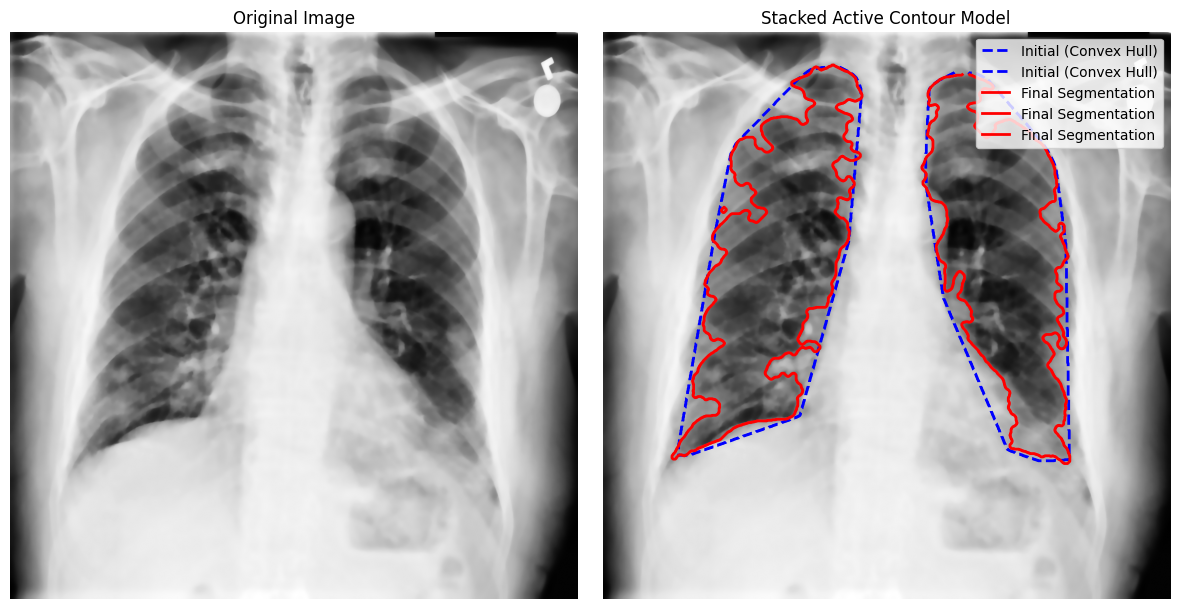

In [290]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import morphological_chan_vese
from skimage.util import img_as_float

def run_stacked_active_contour(image_path, convex_hull_mask, max_iter=100):
    """
    Convex Hull 마스크를 초기값(Start)으로 사용하여
    Active Contour가 폐 영역으로 수렴하는 과정을 수행합니다.
    """
    
    # 1. 원본 이미지 로드 및 전처리
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("이미지를 불러올 수 없습니다.")
    
    # [논문 핵심] CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # ARDS나 뿌연 폐 이미지의 경계를 뚜렷하게 만들기 위해 대비를 향상시킵니다.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img)
    
    # scikit-image는 0~1 사이의 float 타입을 사용합니다.
    image_float = img_as_float(img_enhanced)
    
    # 2. 초기 레벨 셋 설정 (Convex Hull 사용)
    # Convex Hull 마스크가 없으면 작동하지 않으므로 필수 입력입니다.
    init_level_set = convex_hull_mask.copy()
    
    # -----------------------------------------------------------
    # Active Contour 실행 (Morphological Chan-Vese)
    # -----------------------------------------------------------
    # smoothing: 논문의 Total Variation(TV) 항과 유사. 클수록 경계가 매끄러움.
    # lambda1, lambda2: 내부/외부 영역 가중치. 
    # iter: 반복 횟수. 이 횟수만큼 곡선이 수축합니다.
    
    # 시각화를 위해 중간 과정을 캡처할 수도 있지만, 
    # 여기서는 최종 결과 도출을 메인으로 합니다.
    final_level_set = morphological_chan_vese(
        image_float, 
        num_iter=max_iter,
        init_level_set=init_level_set, # Convex Hull에서 시작!
        smoothing=3,                   # 1~4 권장 (노이즈가 심하면 높임)
        lambda1=1,
        lambda2=1
    )
    
    # Boolean 결과를 0~255 마스크로 변환
    final_mask = final_level_set.astype(np.uint8) * 255
    
    return img, img_enhanced, final_mask

# --- 시각화 함수 (논문의 Figure처럼 표현) ---
def visualize_stacked_result(img, init_mask, final_mask):
    plt.figure(figsize=(12, 6))
    
    # 윤곽선 추출
    contours_init, _ = cv2.findContours(init_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_final, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 1. 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # 2. Stacked Active Contour Visualization
    # 원본 위에 초기값(Convex Hull)과 최종값(Final)을 겹쳐서 표시
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    
    # 초기값 (Convex Hull) - 파란색 점선
    for cnt in contours_init:
        # matplotlib에 그리기 위해 좌표 변환 (N, 1, 2) -> (N, 2)
        cnt = cnt.squeeze() 
        if len(cnt.shape) == 2:
            plt.plot(cnt[:, 0], cnt[:, 1], 'b--', linewidth=2, label='Initial (Convex Hull)')
            
    # 최종값 (Final Result) - 빨간색 실선
    for cnt in contours_final:
        cnt = cnt.squeeze()
        if len(cnt.shape) == 2:
            plt.plot(cnt[:, 0], cnt[:, 1], 'r-', linewidth=2, label='Final Segmentation')
            
    plt.title("Stacked Active Contour Model")
    plt.legend(loc='upper right')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- 실행 예시 (이전 단계 코드로 만든 변수 사용 가정) ---
# 예: process_folder_convex_hull 함수 내에서 호출하거나,
# 저장된 파일을 불러와서 실행

image_file = "C:/project/lungX/CXR8/image_set/PA/No Finding/tv_denoised/00000002_000.png"
hull_mask_file = "C:/project/lungX/CXR8/image_set/PA/No Finding/tv_denoised/convex_hull_masks/00000002_000.png" # 이전 단계에서 생성한 파일

hull_mask = cv2.imread(hull_mask_file, cv2.IMREAD_GRAYSCALE)
img, enhanced, result_mask = run_stacked_active_contour(image_file, hull_mask, max_iter=100)

visualize_stacked_result(img, hull_mask, result_mask)


시각화 함수

In [ ]:

# -------------------------------------------------------------------------
# 2. 시각화 및 저장 함수 (수정됨: plt.show -> plt.savefig)
# -------------------------------------------------------------------------
def save_visualization(save_path, img, init_mask, final_mask):
    plt.figure(figsize=(12, 6))
    
    # 윤곽선 추출
    contours_init, _ = cv2.findContours(init_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_final, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # (1) 원본 이미지
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image (Enhanced)")
    plt.axis('off')
    
    # (2) Stacked Active Contour (겹쳐 그리기)
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    
    # 초기값 (Convex Hull) - 파란색 점선
    for cnt in contours_init:
        cnt = cnt.squeeze() 
        if len(cnt.shape) == 2:
            plt.plot(cnt[:, 0], cnt[:, 1], 'b--', linewidth=2, label='Initial (Convex Hull)')
            
    # 최종값 (Final Result) - 빨간색 실선 
    for cnt in contours_final:
        cnt = cnt.squeeze()
        if len(cnt.shape) == 2:
            plt.plot(cnt[:, 0], cnt[:, 1], 'r-', linewidth=2, label='Final Segmentation')
            
    # 범례는 하나만 표시되도록 처리 (중복 방지)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.title("Stacked Active Contour Model")
    plt.axis('off')
    
    plt.tight_layout()
    # 파일로 저장 후 메모리 해제 (중요)
    plt.savefig(save_path)
    plt.close()


### 전체 실행 코드


In [17]:
import os

# [핵심 1] 환경 변수 설정: 라이브러리 임포트보다 무조건 위에 있어야 함
# CPU 코어끼리 경쟁(Thrashing)하는 것을 막고, 각 프로세스가 독립적으로 1코어씩만 쓰게 강제함.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import cv2
import numpy as np
import glob
import time
import sys
from joblib import Parallel, delayed, cpu_count
from tqdm import tqdm
from skimage.segmentation import morphological_chan_vese
from skimage.util import img_as_float

# -------------------------------------------------------------
# [알고리즘 로직] 설정값 수정됨 (70회 / 7회)
# -------------------------------------------------------------
def fast_active_contour_logic(raw_img, hull_mask):
    TARGET_SIZE = (512, 512)
    SMALL_SIZE = (128, 128)
    
    # 1. 리사이즈 (속도 최적화)
    # 이미지: 보간법 적용 / 마스크: 값 유지(Nearest)
    img_512 = cv2.resize(raw_img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    mask_512 = cv2.resize(hull_mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
    
    # 2. 전처리 (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_512)
    img_float_512 = img_as_float(img_enhanced)
    
    # 3. [Stage 1] 128px Coarse Optimization (큰 윤곽 잡기)
    img_small = cv2.resize(img_float_512, SMALL_SIZE, interpolation=cv2.INTER_AREA)
    mask_small = cv2.resize(mask_512, SMALL_SIZE, interpolation=cv2.INTER_NEAREST)
    
    cv_mask_small = morphological_chan_vese(
        img_small, 
        num_iter=70,        # [요청반영] 50 -> 70회로 증가
        init_level_set=mask_small, 
        smoothing=2, 
        lambda1=1, lambda2=1
    )
    
    # 4. [Stage 2] 512px Fine Tuning (미세 조정)
    mask_upscaled = cv2.resize(cv_mask_small.astype(np.float32), TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
    
    final_cv_mask = morphological_chan_vese(
        img_float_512, 
        num_iter=7,         # [요청반영] 5 -> 7회로 증가
        init_level_set=mask_upscaled, 
        smoothing=3, 
        lambda1=1, lambda2=1
    )
    
    return (final_cv_mask.astype(np.uint8)) * 255

# -------------------------------------------------------------
# [Worker] 개별 작업자 (이중 안전장치 추가)
# -------------------------------------------------------------
def process_worker(mask_path, raw_dir, output_dir):
    # [핵심 2] 프로세스 내부 스레드 차단 (이중 잠금)
    # 윈도우 환경에서 Joblib/Multiprocessing 사용 시 필수 안전장치
    cv2.setNumThreads(0)
    
    try:
        filename = os.path.basename(mask_path)
        save_path = os.path.join(output_dir, filename)
        
        # [Skip] 이미 처리된 파일 건너뛰기
        if os.path.exists(save_path): return 0 

        raw_path = os.path.join(raw_dir, filename)
        
        # 파일 읽기 확인
        if not os.path.exists(raw_path): return None
        
        hull_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        raw_img = cv2.imread(raw_path, cv2.IMREAD_GRAYSCALE)

        if hull_mask is None or raw_img is None: return None

        # 알고리즘 수행
        result_mask = fast_active_contour_logic(raw_img, hull_mask)

        # 저장 (압축률 1: 속도 빠름, 용량 적당함)
        cv2.imwrite(save_path, result_mask, [cv2.IMWRITE_PNG_COMPRESSION, 1])
        
        return 1 # 성공 처리 1 반환

    except Exception as e:
        # 에러 발생 시 파일명과 에러 내용 반환
        return f"{filename}: {e}"

# -------------------------------------------------------------
# [Main] 실행부
# -------------------------------------------------------------
def main():
    # # 경로 설정
    # # full data
    # INPUT_HULL_DIR = "D:/lung_xray/final_denoised/mask_CH"
    # INPUT_RAW_DIR = "D:/lung_xray/final_denoised"
    # OUTPUT_DIR = "D:/lung_xray/final_denoised/mask_ACM"

    # 경로 설정
    # 성능평가를 위한 샘플데이터
    INPUT_HULL_DIR = "D:/nodules-in-chest-xrays-jsrt/mask_CH"
    INPUT_RAW_DIR = "D:/nodules-in-chest-xrays-jsrt/images_clean"
    OUTPUT_DIR = "D:/nodules-in-chest-xrays-jsrt/mask_ACM"


    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    mask_files = glob.glob(os.path.join(INPUT_HULL_DIR, '*.png'))
    total_files = len(mask_files)
    
    if total_files == 0:
        print("❌ 처리할 파일이 없습니다.")
        return

    # [핵심 3] CPU 코어 할당 전략
    # n_jobs=-1: 모든 코어 사용. 
    # 만약 컴퓨터가 멈추는 느낌이 들면 -2 (코어 1개 남김)로 변경하세요.
    n_jobs = -1 
    
    print(f"===========================================================")
    print(f"🔥 MAX PERFORMANCE MODE (Joblib + Generator)")
    print(f"===========================================================")
    print(f"💻 Active Cores    : {cpu_count()} (Target: {n_jobs})")
    print(f"📂 Total Images    : {total_files}")
    print(f"⚙️  Iterations      : 128px(70iter) -> 512px(7iter)")
    print(f"===========================================================")

    start_time = time.time()

    # [핵심 4] Joblib Generator를 이용한 실시간 TQDM 연동
    # return_as='generator'를 사용하면 결과가 나오는 족족 tqdm이 업데이트됩니다.
    # 배치 단위 멈춤 현상이 사라집니다.
    
    with tqdm(total=total_files, unit="img", desc="Processing") as pbar:
        results_generator = Parallel(n_jobs=n_jobs, return_as='generator')(
            delayed(process_worker)(f, INPUT_RAW_DIR, OUTPUT_DIR) 
            for f in mask_files
        )
        
        error_logs = []
        count = 0
        
        # 제너레이터에서 결과를 하나씩 꺼내며 진행바 업데이트
        for res in results_generator:
            if isinstance(res, str): # 에러 메시지인 경우
                error_logs.append(res)
            elif res == 1: # 신규 처리
                count += 1
            # res == 0 인 경우(Skip)도 진행률은 올라감
            
            pbar.update(1)

    end_time = time.time()
    duration = end_time - start_time
    
    print(f"\n✅ 완료! 총 소요 시간: {duration:.2f}초")
    print(f"⏱️ 평균 속도: {duration/total_files:.4f}초/장")
    
    if error_logs:
        print(f"\n⚠️ {len(error_logs)}개의 에러 발생:")
        for err in error_logs[:5]:
            print(f" - {err}")

if __name__ == '__main__':
    main()

🔥 MAX PERFORMANCE MODE (Joblib + Generator)
💻 Active Cores    : 22 (Target: -1)
📂 Total Images    : 247
⚙️  Iterations      : 128px(70iter) -> 512px(7iter)


Processing: 100%|██████████| 247/247 [00:23<00:00, 10.60img/s]


✅ 완료! 총 소요 시간: 23.31초
⏱️ 평균 속도: 0.0944초/장


# Final Segmentation 마스크 시각화


In [18]:
import os
import cv2
import numpy as np
import matplotlib

# [핵심 1] 환경 변수 설정 (CPU 점유율 최적화 및 충돌 방지)
# 라이브러리 임포트 전에 설정해야함
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# [핵심 2] GUI 없는 백엔드 설정 (병렬 처리 시 필수)
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import glob
import time
from joblib import Parallel, delayed, cpu_count
from tqdm import tqdm
from skimage.segmentation import morphological_chan_vese
from skimage.util import img_as_float

# -------------------------------------------------------------------------
# 1. 핵심 알고리즘: 진화 과정 캡처
# -------------------------------------------------------------------------
def capture_stacked_evolution(raw_img, convex_hull_mask, total_iter=30, step_iter=10):
    """
    초기값 : Convex Hull 마스크
    목적 : 중간 과정에 생성되는 마스크들을 모두 수집하여 반환 (레이어링)
    """
    # 전처리
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(raw_img)
    image_float = img_as_float(img_enhanced)
    
    # 진화 과정을 저장할 리스트 (첫 번째는 초기값인 Convex Hull)
    evolution_masks = [convex_hull_mask.copy()]
    # 현재 초기 레벨 셋 설정
    current_level_set = convex_hull_mask.copy()
    # step_iter 간격으로 Active Contour 실행
    num_steps = total_iter // step_iter
    
    # (병렬 처리 중 print는 로그가 섞이므로 제거하거나 주석 처리)
    # print(f" -> Evolution capturing... ({num_steps} steps)")
    
    for _ in range(num_steps):
        current_level_set = morphological_chan_vese(
            image_float, 
            num_iter=step_iter,
            init_level_set=current_level_set,
            smoothing=3,
            lambda1=1,
            lambda2=1
        )
        # 결과 저장 (Boolean -> 0~255 uint8)
        current_mask = current_level_set.astype(np.uint8) * 255
        evolution_masks.append(current_mask)

    # 원본 이미지(전처리됨)와 모든 단계의 마스크 리스트 반환    
    return img_enhanced, evolution_masks

# -------------------------------------------------------------------------
# 2. 시각화 및 저장 함수 (최적화됨)
# -------------------------------------------------------------------------
def visualize_stacked_evolution(save_path, img, evolution_masks):
    """ 
    목적 : 수집된 모든 마스크의 윤곽선을 원본 이미지 위에 파란색으로 겹쳐 그려 마스크 과정 시각화.
    """


    # [핵심 3] 객체 지향 방식 사용 (메모리 관리)
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 배경
    ax.imshow(img, cmap='gray')
    
    # 윤곽선 그리기
    for i, mask in enumerate(evolution_masks):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        alpha_val = 0.6
        line_width = 1.5

        for cnt in contours:
            cnt = cnt.squeeze()
            if len(cnt.shape) == 2:
                ax.plot(cnt[:, 0], cnt[:, 1], color='blue', linewidth=line_width, alpha=alpha_val)

    # 스타일 설정
    ax.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
    # 저장 및 닫기 (메모리 누수 방지)
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# -------------------------------------------------------------------------
# 3. 워커 함수 (개별 이미지 처리)
# -------------------------------------------------------------------------
def process_single_image(file_path, raw_dir, output_vis_dir, output_mask_dir):
    # OpenCV 스레드 잠금 (Joblib 충돌 방지)
    # 해당 작업을 수행하지 않으면 CPU가 영원히 대기상태에 빠져 코드가 수행되지 않음
    cv2.setNumThreads(0)
    
    try:
        filename = os.path.basename(file_path)
        vis_save_path = os.path.join(output_vis_dir, f"stacked_vis_{filename}")

        # [이어하기 기능] 이미 결과가 있으면 스킵 (속도 향상)
        if os.path.exists(vis_save_path):
            return 0 

        # 파일 로드
        hull_mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        raw_path = os.path.join(raw_dir, filename)
        
        if not os.path.exists(raw_path): return None
        raw_img = cv2.imread(raw_path, cv2.IMREAD_GRAYSCALE)
        
        if hull_mask is None or raw_img is None: return None

        # 크기 맞추기
        if raw_img.shape != hull_mask.shape:
            raw_img = cv2.resize(raw_img, (hull_mask.shape[1], hull_mask.shape[0]))

        # 알고리즘 실행 (Active Contour)
        enhanced_img, evolution_masks = capture_stacked_evolution(
            raw_img, 
            hull_mask, 
            total_iter=30,  # 필요에 따라 조절
            step_iter=10
        )
        
        # 시각화 저장 (Matplotlib)
        visualize_stacked_evolution(vis_save_path, enhanced_img, evolution_masks)
        
        # 최종 마스크 저장 (옵션)
        if output_mask_dir:
            final_mask = evolution_masks[-1]
            cv2.imwrite(os.path.join(output_mask_dir, filename), final_mask)
            
        return 1 # 성공

    except Exception as e:
        return f"{filename}: {e}"

# -------------------------------------------------------------------------
# 4. 메인 실행부 (병렬 처리 관리)
# -------------------------------------------------------------------------
def main():
    # # --- 경로 설정 ---
    # # 실제 데이터
    # INPUT_HULL_DIR = "D:/lung_xray/final_denoised/mask_ACM"
    # INPUT_RAW_DIR = "D:/lung_xray/final_denoised"
    # OUTPUT_VIS_DIR = "D:/lung_xray/final_denoised/stacked_visualization"
    # OUTPUT_MASK_DIR = "D:/lung_xray/final_contour_masks"


    # --- 경로 설정 ---
    # 성능평가를 위한 샘플데이터
    INPUT_HULL_DIR = "D:/nodules-in-chest-xrays-jsrt//mask_ACM"
    INPUT_RAW_DIR = "D:/nodules-in-chest-xrays-jsrt/images_clean"
    OUTPUT_VIS_DIR = "D:/nodules-in-chest-xrays-jsrt/stacked_visualization"
    OUTPUT_MASK_DIR = "D:/nodules-in-chest-xrays-jsrt/final_contour_masks"

    # 폴더 생성
    if not os.path.exists(OUTPUT_VIS_DIR): os.makedirs(OUTPUT_VIS_DIR)
    if OUTPUT_MASK_DIR and not os.path.exists(OUTPUT_MASK_DIR): os.makedirs(OUTPUT_MASK_DIR)

    # 파일 리스트 확정 (Glob을 미리 수행하여 리스트를 고정함 -> 무한루프 방지)
    mask_files = glob.glob(os.path.join(INPUT_HULL_DIR, '*.png'))
    total_files = len(mask_files)
    
    if total_files == 0:
        print("❌ 처리할 파일이 없습니다.")
        return

    # CPU 코어 수 확인
    n_jobs = -1 # 모든 코어 사용
    # n_jobs = -2 # (너무 버벅이면 코어 1개 남겨두기)

    print(f"===========================================================")
    print(f"🔥 MAX PERFORMANCE MODE (Active Contour Visualization)")
    print(f"===========================================================")
    print(f"💻 CPU Cores : {cpu_count()} (Using: All)")
    print(f"📂 Images    : {total_files}")
    print(f"===========================================================")

    # 병렬 처리 실행
    # return_as='generator'를 통해 결과가 나오는 즉시 tqdm 업데이트
    with tqdm(total=total_files, unit="img", desc="Processing") as pbar:
        results = Parallel(n_jobs=n_jobs, backend='loky', return_as='generator')(
            delayed(process_single_image)(
                f, INPUT_RAW_DIR, OUTPUT_VIS_DIR, OUTPUT_MASK_DIR
            ) for f in mask_files
        )

        error_logs = []
        for res in results:
            if isinstance(res, str): # 에러 메시지 반환 시
                error_logs.append(res)
            # 성공(1)이나 스킵(0)인 경우 모두 진행률 업데이트
            pbar.update(1)

    print("\n✅ 모든 처리가 완료되었습니다.")
    if error_logs:
        print(f"⚠️ 에러 발생: {len(error_logs)}건")
        for err in error_logs[:5]:
            print(f" - {err}")

if __name__ == "__main__":
    main()

🔥 MAX PERFORMANCE MODE (Active Contour Visualization)
💻 CPU Cores : 22 (Using: All)
📂 Images    : 247


Processing: 100%|██████████| 247/247 [01:14<00:00,  3.31img/s]


✅ 모든 처리가 완료되었습니다.
